In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import load

from glob import glob
import pandas as pd
import os
from matplotlib.backends.backend_pdf import PdfPages

In [32]:
stacking_strategies = ["igcngru_features", "idarkvec", "features"]

stacking_strategies.sort()
with_nodes = "vanilla-us"
target_day = "20221021"

probs_cols = [
    "censys",
    "driftnet",
    "internetcensus",
    "intrinsec",
    "ipip",
    "mirai",
    "onyphe",
    "rapid7",
    "securitytrails",
    "shadowserver",
    "shodan",
    "u_mich",
    "unk_bruteforcer",
    "unk_exploiter",
    "unk_spammer",
    "unknown",
]
probs_cols.sort()

In [33]:
strats_posfix = "-".join(sorted(stacking_strategies))

In [35]:
model = load(
    f"../data/2022/output/stacking_data/{with_nodes}/{target_day}/{strats_posfix}/0/lr.joblib"
)

In [36]:
model.classes_

array(['censys', 'driftnet', 'internetcensus', 'intrinsec', 'ipip',
       'mirai', 'onyphe', 'securitytrails', 'shadowserver', 'shodan',
       'u_mich', 'unk_bruteforcer', 'unk_exploiter', 'unk_spammer',
       'unknown'], dtype=object)

In [37]:
model.coef_.shape

(15, 48)

In [38]:
days = sorted(
    [
        f.split("/")[-1].split("_")[-2]
        for f in glob(f"../data/2022/input/stacking_predictions/out/k3/test/idarkvec*_fold00.csv")
    ]
)
days

['20221021',
 '20221022',
 '20221023',
 '20221024',
 '20221025',
 '20221026',
 '20221027',
 '20221028',
 '20221029',
 '20221030',
 '20221031']

In [40]:
def get_coeffs(with_nodes, day, strats_posfix):

    coeffs = []
    for fold in np.arange(10):
        model = load(
            f"../data/2022/output/stacking_data/{with_nodes}/{day}/{strats_posfix}/{fold}/lr.joblib"
        )
        coeffs.append(model.coef_)

    coeffs = np.sum(coeffs, axis=0)
    coeffs = coeffs / 10
    return coeffs, model


def format(coeffs, probs_cols, stacking_strategies, with_nodes):

    xl = []
    for s in stacking_strategies:
        for i, c in enumerate(probs_cols):
            xl.append(f"{s} / {c}")

    if with_nodes == "vanilla":
        for i in np.arange(coeffs.shape[1] - len(xl)):
            xl.append(f"Node Feature: {i}")

    return xl

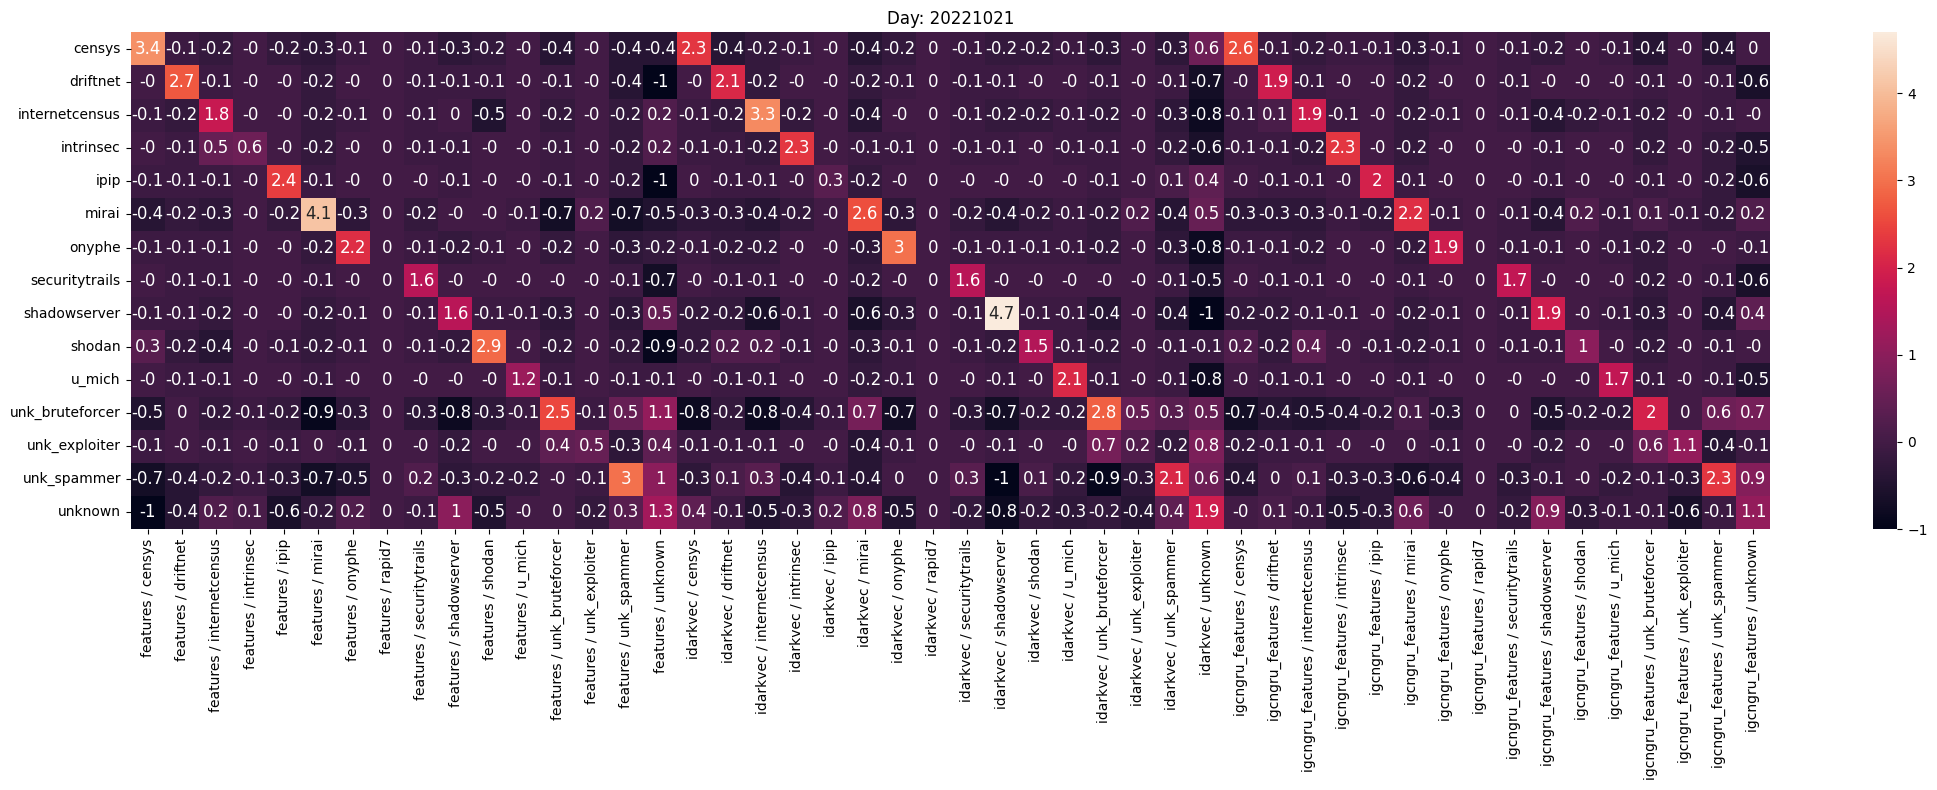

In [43]:
coeffs, model = get_coeffs(with_nodes, "20221021", strats_posfix)
xl = format(coeffs, probs_cols, stacking_strategies, with_nodes)
plt.figure(figsize=(22, 8))
sns.heatmap(
    np.trunc(coeffs * 10) / 10,
    annot=True,
    annot_kws={"size": 12},
    yticklabels=model.classes_,
    xticklabels=xl,
)
plt.title(f"Day: 20221021")
plt.tight_layout()

In [44]:
with PdfPages("../pdfs/charts/days_lr_coefs.pdf") as pdf:
    for day in days:
        coeffs, model = get_coeffs(with_nodes, day, strats_posfix)
        xl = format(coeffs, probs_cols, stacking_strategies, with_nodes)
        plt.figure(figsize=(16, 8))
        sns.heatmap(
            np.trunc(coeffs * 10) / 10,
            annot=True,
            annot_kws={"size": 12},
            yticklabels=model.classes_,
            xticklabels=xl,
        )
        plt.title(f"Day: {day}")
        plt.tight_layout()
        pdf.savefig(bbox_inches="tight")
        plt.close()